# Fake News Detection using RNN

In [1]:
#Importing required libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')


In [3]:
#Reading the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls "/content/gdrive/My Drive/RealVSFake"

Fake.csv  News.zip  True.csv  Untitled.ipynb


In [7]:
Fake_df = pd.read_csv('/content/gdrive/My Drive/RealVSFake/Fake.csv')
Real_df = pd.read_csv('/content/gdrive/My Drive/RealVSFake/True.csv')

In [8]:
Fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
Real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
# Now we will check for missing values in both the datasets

Fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [11]:
Real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

So we see that there are no missing values in both the datasets.

In [12]:
Fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [13]:
Real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Also we can induce that there would be any strong correlation between the Date and the class of the news.So, we would drop the Date column from both the datasets. Also topics in subject column are different for both categories i.e. subjects are not distributed evenly and can effect our performance of classifier. So we will drop subject column too.

In [14]:
Fake_df.drop(['date', 'subject'], axis=1, inplace=True)
Real_df.drop(['date', 'subject'], axis=1, inplace=True)

In [15]:
# Now creating a column for labelling the type of news in the dataset.
Fake_df['class'] = 0 
Real_df['class'] = 1


Now looking the proportion of fake and real news.

Text(0, 0.5, '# of News Articles')

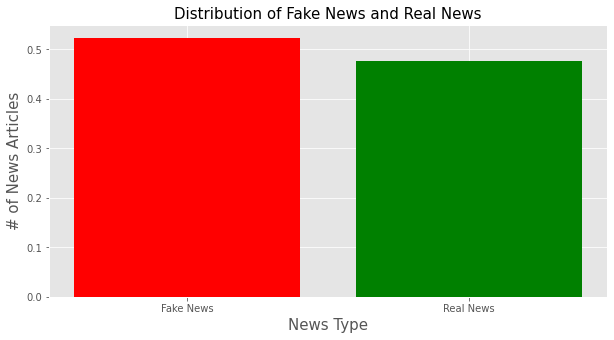

In [17]:
df_total = len(Fake_df) + len(Real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(Fake_df)/df_total, color='red')
plt.bar('Real News', len(Real_df)/df_total, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

Merging the two datasets into one.

In [18]:
df_news = pd.concat([Fake_df, Real_df], ignore_index=True, sort=False)
df_news

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [19]:
# Merging the text column and title into one column for simplicity
df_news['text'] = df_news['title'] + " " + df_news['text']
df_news.drop('title',axis=1,inplace = True)

Splitting dataset to train and test data

In [20]:
features = df_news['text']
target = df_news['class']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=18)

# Data Preprocessing

Normalizing our data: lower case, get rid of extra spaces, and url links.

In [21]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [22]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Converting text to vectors , as our classifier only understands numeric data

In [23]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Padding for same length of input data i.e for text length of input to not be varying for different articles

In [24]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

#Modeling

Building the RNN

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

Early Stopping if no improvement in validation loss

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 406s 371ms/step - loss: 0.4554 - accuracy: 0.7181 - val_loss: 0.0820 - val_accuracy: 0.9758
Epoch 2/10
1078/1078 [==============================] - 404s 375ms/step - loss: 0.0665 - accuracy: 0.9816 - val_loss: 0.0418 - val_accuracy: 0.9858
Epoch 3/10
1078/1078 [==============================] - 403s 374ms/step - loss: 0.0335 - accuracy: 0.9918 - val_loss: 0.0596 - val_accuracy: 0.9833
Epoch 4/10
1078/1078 [==============================] - 404s 375ms/step - loss: 0.0218 - accuracy: 0.9948 - val_loss: 0.0287 - val_accuracy: 0.9922
Epoch 5/10
1078/1078 [==============================] - 402s 373ms/step - loss: 0.0110 - accuracy: 0.9977 - val_loss: 0.0324 - val_accuracy: 0.9894
Epoch 6/10
1078/1078 [==============================] - 401s 372ms/step - loss: 0.0114 - accuracy: 0.9976 - val_loss: 0.0400 - val_accuracy: 0.9883


Visualising the training over epochs

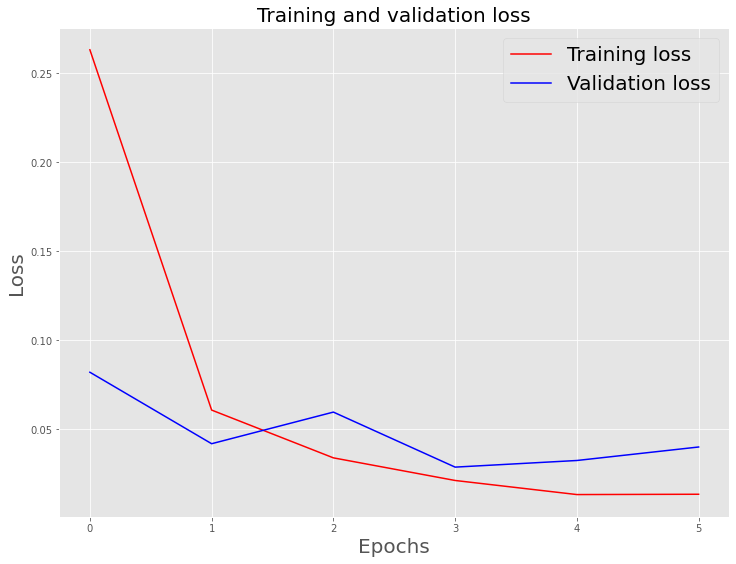

In [29]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()


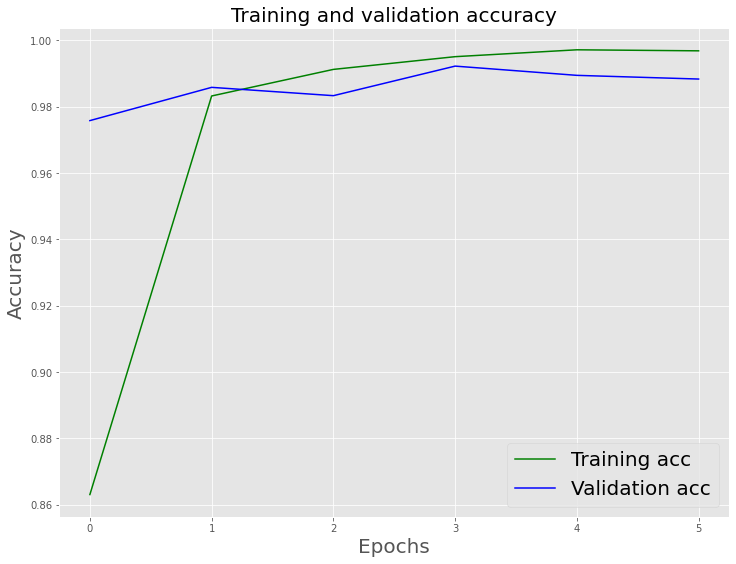

In [34]:
plt.figure(figsize=(12,9))
plt.title('Training and validation accuracy', size=20)
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})

plt.show()

Evaluate testing set

In [35]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 20s 72ms/step - loss: 0.0376 - accuracy: 0.9899


[0.03758034482598305, 0.9898663759231567]

In [36]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [37]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9898663697104677
Precision on testing set: 0.9872626215840667
Recall on testing set: 0.9916259595254711


Confusion Matrix

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

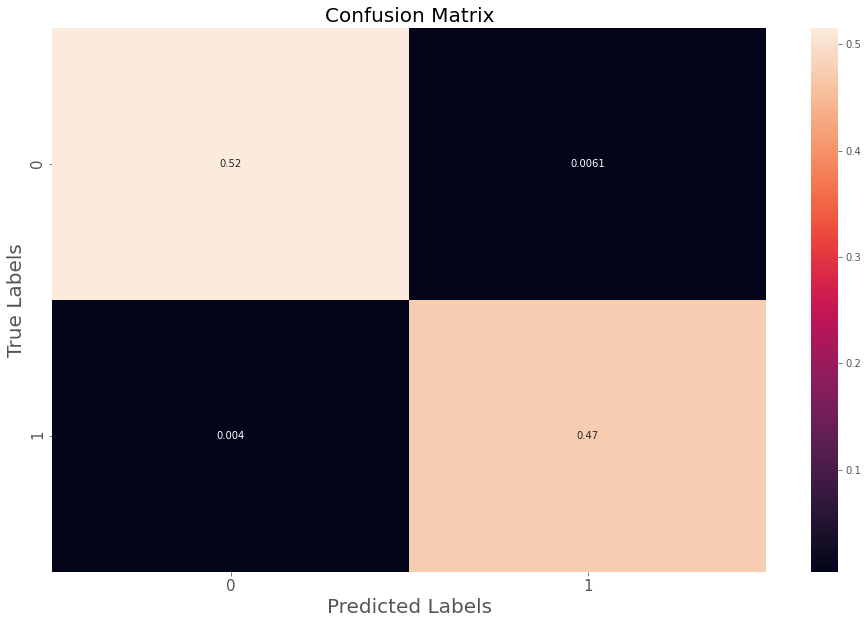

In [38]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

#Conclusion

RNN is working very well on our dataset for classification of news with the following result - 
- Accuracy on testing set: 0.9898663697104677
- Precision on testing set: 0.9872626215840667
- Recall on testing set: 0.9916259595254711 